In [1]:
import torch 
import torch.nn as nn
import torchvision
import torch.nn.functional as F

In [2]:
torch.__version__

'1.9.1'

In [3]:
from simgd.deepnets1m.graph import Graph, GraphBatch
from simgd.ghn.nn import GHN

In [4]:
class Net(nn.Module):
    def __init__(self,channels=32):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, channels, kernel_size=5)
        self.conv2 = nn.Conv2d(channels, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [5]:
model = Net()

#model = nn.Sequential(
#        nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#        nn.ReLU(),
#        nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#        nn.ReLU(),
#        nn.Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#        nn.ReLU(),
#        nn.Flatten(),
#        nn.Linear(32*32,10)
#)
model.expected_image_sz = (1,28,28)

/Users/jean72human/anaconda3/envs/thesis_sim_grad/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


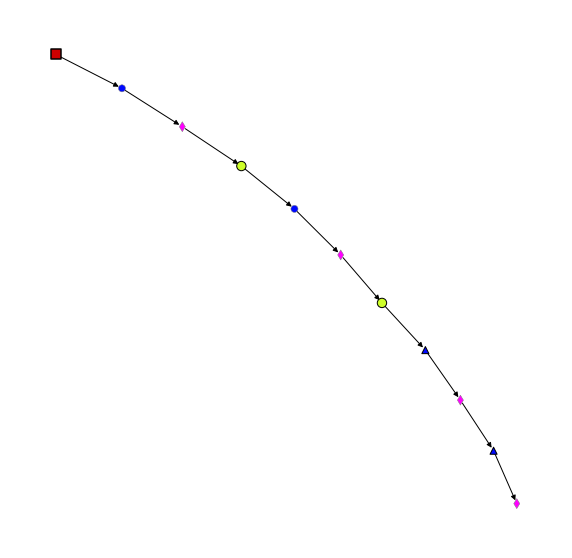

In [6]:
g = Graph(model)
g.visualize()
g.edges = torch.cat([g.edges,torch.zeros((g.edges.size(0),1))],dim=1).long()
g.node_feat = torch.cat([g.node_feat,torch.zeros((g.node_feat.size(0),1))],dim=1)

In [7]:
ghn = GHN([512,512,5,5],10)

In [8]:
outs = ghn(model,g)

In [9]:
for o in outs:
    print(o.shape)

torch.Size([10, 1, 5, 5])
torch.Size([10])
torch.Size([20, 10, 5, 5])
torch.Size([20])
torch.Size([50, 320])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [15]:
g.n_nodes

11

In [17]:
g.node_params

[('input', 'input'),
 ('conv', 'conv1.weight'),
 ('bias', 'conv1.bias'),
 ('max_pool', 'MaxPool2DWithIndicesBackward'),
 ('conv', 'conv2.weight'),
 ('bias', 'conv2.bias'),
 ('max_pool', 'MaxPool2DWithIndicesBackward'),
 ('conv', 'fc1.weight'),
 ('bias', 'fc1.bias'),
 ('conv', 'fc2.weight'),
 ('bias', 'fc2.bias')]

In [ ]:
loss = torch.nn.CrossEntropyLoss()(model(torch.rand((1,3,32,32))),torch.rand((1,10)).argmax(1))
loss.backward()

In [ ]:
for p in model.parameters():
    print(p.grad.shape)

torch.Size([3, 3, 3, 3])
torch.Size([3])
torch.Size([3, 3, 3, 3])
torch.Size([3])
torch.Size([1, 3, 3, 3])
torch.Size([1])
torch.Size([10, 1024])
torch.Size([10])


In [5]:
from simgd.ghn.encoder import MLPEncoder, ConvEncoder
from simgd.ghn.decoder import MLPDecoder, ConvDecoder

In [6]:
conv_enc = ConvEncoder([3, 3, 3, 3])
conv_dec = ConvDecoder([3, 3, 3, 3])
bias_enc = nn.Linear(3,32)
bias_dec = nn.Linear(32,3)
linear_enc = MLPEncoder([1024,1024])
linear_dec = MLPDecoder([1024,1024])

In [7]:
model.state_dict()["0.weight"].shape

torch.Size([1, 3, 3, 3])

In [8]:
var = torch.zeros([64,64,3,3])
var.view(-1,*var.shape[2:]).shape

torch.Size([4096, 3, 3])

In [9]:
nn.Linear(1152,32)(nn.Conv2d(4096, 128, 1)(torch.zeros([4096,3,3]).unsqueeze(0)).view(-1)).shape

torch.Size([32])

In [10]:
var = conv_enc(torch.zeros([3,3,3,3]))
var.shape

torch.Size([1152])


torch.Size([32])

In [11]:
conv_dec(var).shape

torch.Size([3, 3, 3, 3])

In [ ]:
g.node_params

['input',
 '0.weight',
 '0.bias',
 '2.weight',
 '2.bias',
 '4.weight',
 '4.bias',
 '7.weight',
 '7.bias']

In [ ]:
g.node_info

[[(1, '0.weight', 'conv', torch.Size([3, 3, 3, 3]), False, False),
  (2, '0.bias', 'bias', torch.Size([3]), False, False),
  (3, '2.weight', 'conv', torch.Size([3, 3, 3, 3]), False, False),
  (4, '2.bias', 'bias', torch.Size([3]), False, False),
  (5, '4.weight', 'conv', torch.Size([1, 3, 3, 3]), False, False),
  (6, '4.bias', 'bias', torch.Size([1]), False, False),
  (7, '7.weight', 'conv', torch.Size([10, 1024]), True, False),
  (8, '7.bias', 'bias', torch.Size([10]), False, True)]]

In [ ]:
g._Adj.shape

torch.Size([9, 9])

In [ ]:
len(g._nodes)

9

In [ ]:
torch.zeros((2,3)).size(0)

2